In [1]:
!pip install cvxopt

In [119]:
def plot_decision(clf, X, y, cmap='Set1'):    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, s=80, label='Training points')

    # Circle out the test data
    plt.scatter(X[clf.support, 0], X[clf.support, 1], s=200, facecolors='none',
                zorder=10, edgecolor='k', cmap=cmap, label='Support Vectors')

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    x_min -= 0.05 * np.abs(x_max - x_min)
    x_max += 0.05 * np.abs(x_max - x_min)
    y_min = X[:, 1].min() * 1.1
    y_max = X[:, 1].max() * 1.1
    y_min -= 0.05 * np.abs(y_max - y_min)
    y_max += 0.05 * np.abs(y_max - y_min)

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
#     plt.pcolormesh(XX, YY, Z > 0, cmap=cmap)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-1, 0, 1])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend()

In [115]:
import cvxpy as cvx
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import pairwise

class SVM(BaseEstimator, ClassifierMixin):

    def __init__(self, C=1., kernel='linear', kernel_params={}, verbose=False, max_iter=10000, solver=cvx.OSQP):
        self.C = C
        self.kernel_params = kernel_params
        self.kernel = kernel

        self.coef = None
        self.bias = None
        self.labels = None
        self.y = None
        self.X = None
        self.eps = 1e-9
        self.sparsity = None
        self.verbose = verbose
        self.max_iter = max_iter
        self.solver = solver

    def gramm_matrix(self, X, Y=None):
        if self.kernel == 'linear':
            K = pairwise.linear_kernel(X, Y=Y)
        elif self.kernel == 'poly':
            K = pairwise.polynomial_kernel(X, Y=Y, **self.kernel_params)
        elif self.kernel == 'rbf':
            K = pairwise.rbf_kernel(X, Y=Y, **self.kernel_params)
        else:
            raise NotImplementedError
        return K

    def get_signed_gramm_matrix(self, X, y):
        K = self.gramm_matrix(X)
        K *= y[:, np.newaxis]
        K *= y[np.newaxis]
        return K

    def transform_labels(self, y):
        _y = y.copy()
        self.labels = np.array(sorted(np.unique(y)))
        assert len(self.labels) == 2
        _y[_y == self.labels[0]] = -1
        _y[_y == self.labels[1]] = 1
        return _y

    def fit(self, X, y):
        if len(np.unique(y)) > 2:
            raise RuntimeError

        self.y, self.X = self.transform_labels(y), X.copy()

        n, d = self.X.shape
        lambd = cvx.Variable(shape=(n,))
        K = self.get_signed_gramm_matrix(self.X, self.y)
        objective = 0.5 * cvx.atoms.quad_form(lambd, K) - cvx.sum(lambd)
        constraints = [
            lambd <= self.C,
            lambd >= 0,
            self.y @ lambd == 0
        ]
        problem = cvx.Problem(cvx.Minimize(objective), constraints=constraints)
        problem.solve(verbose=self.verbose, max_iter=self.max_iter, solver=self.solver, kktsolver='robust', warm_start=True)
        self._status = problem.status

        self.lambd = lambd.value
        self.support = self.lambd > self.eps
        support_boundary = (self.lambd > self.eps) & (
            self.lambd < self.C - self.eps)
        K = self.gramm_matrix(self.X[self.support], self.X[support_boundary])
        self.coef = self.lambd[self.support] * self.y[self.support]
        wx = np.sum(self.coef[:, np.newaxis] * K, axis=0)
        self.bias = np.median(self.y[support_boundary] - wx)

        self.sparsity = 1 - (np.sum(self.support) / len(self.support))

        return self

    def decision_function(self, X):
        K = self.gramm_matrix(self.X[self.support], X)
        wx = np.sum(
            (self.lambd[self.support] * self.y[self.support])[:, np.newaxis] * K, axis=0)
        return wx + self.bias

    def predict(self, X):
        p = self.decision_function(X)
        return self.labels[(p > 0).astype(int)]

In [69]:
#from cvxpysvm import SVM, LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid')
np.random.seed(0)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from sklearn.model_selection import train_test_split

def gen_lin_separable_data(n=2, N=100):
    # generate training data in the 2-d case
    means = np.array([[0], [2]])
    covs = np.array([[[0.3]], [[0.2]]])
    X1 = np.random.multivariate_normal(means[0], covs[0], (N, n))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(means[1], covs[1], (N, n))
    y2 = np.ones(len(X2)) * -1
    X = np.vstack((X1, X2)).reshape((2*N, n))
    y = np.hstack((y1, y2))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    return X_train, y_train, X_test, y_test

## 4. Для каждого значения n $\in$ {2, 10, 20, ..., 100} сгенерируйте N = 100 тестовых примеров

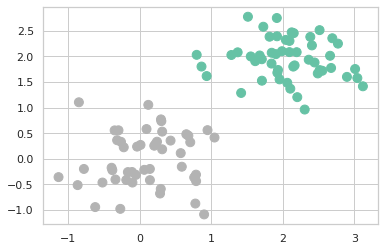

In [135]:
X, y, _, _ = gen_lin_separable_data()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set2', s=80)

## 5. Решите задачу с помощью CVX, исследуйте зависимости:

- Зависимость **среднего по N примерам времени** решения задачи размерности n;

In [ ]:
from datetime import datetime
C = 4
ns = range(2, 103, 5)
num_tries = 10
#for c in C:
times = []

for n in ns:
    start = datetime.now()
    for _ in range(num_tries):
        X_train, y_train, X_test, y_test = gen_lin_separable_data(n=n)
        clf = SVM(kernel='linear', C=C, max_iter=10000, verbose=True, solver=cvx.CVXOPT)
        clf.fit(X_train, y_train)
    end = (datetime.now() - start).total_seconds()
    times.append(end / num_tries)

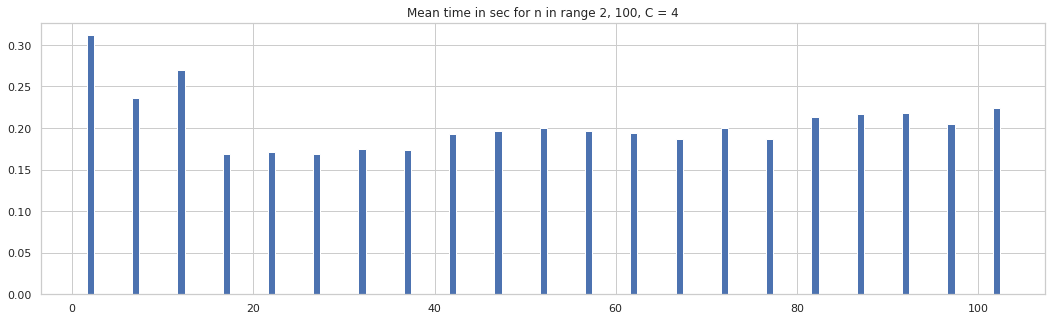

In [118]:
f, ax = plt.subplots(figsize=(18,5))
plt.bar(ns, times)
plt.title(f"Mean time in sec for n in range 2, 100, C = {C}")
plt.show()

- Для случая n=2, проведите графическую интерпретацию результатов

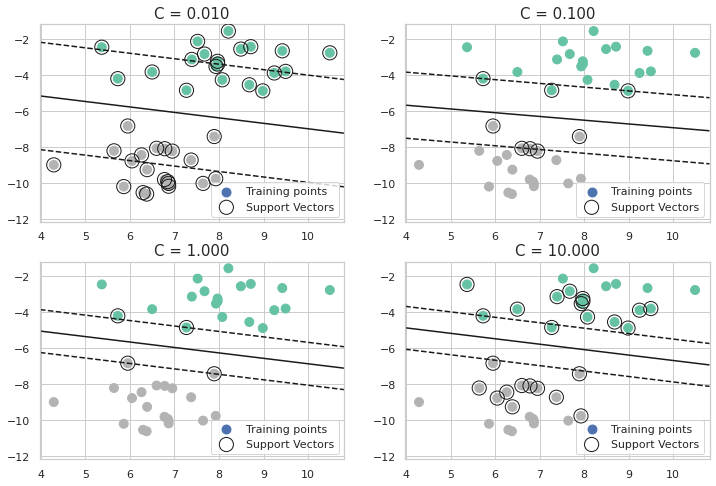

In [133]:
from sklearn.datasets import make_blobs

c_grid = np.logspace(-2, 1, 4)
plt.figure(figsize=(12, 8))
X, y = make_blobs(centers=2, random_state=6, n_samples=40)
for (i, c) in enumerate(c_grid):
    clf = SVM(kernel='linear', C=c, max_iter=10000, verbose=False, solver=cvx.CVXOPT)
    clf.fit(X, y)
    plt.subplot(2, 2, i+1)
    plt.title('C = {:.3f}'.format(c), size=15)
    plot_decision(clf, X, y, cmap='Set2')